<a id="content1"></a>
## 1 ) Importing Various Modules.

In [42]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
#sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess images
from keras.preprocessing.image import ImageDataGenerator

#Deep Learning libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

# specifically for cnn (Convolution Neural Networks)
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

#Transfer Learning
from keras.applications.vgg16 import VGG16

In [3]:
import os
print(os.listdir('../input/flowers-recognition/flowers/flowers'))

['tulip', 'daisy', 'rose', 'dandelion', 'sunflower']


<a id="content2"></a>
## 2 ) Preparing the Data

## 2.1) Making the functions to get the training and validation set from the Images

In [4]:
X=[]
Z=[]
IMG_SIZE=150 # image size for processing
FLOWER_DAISY_DIR='../input/flowers-recognition/flowers/flowers/daisy'
FLOWER_SUNFLOWER_DIR='../input/flowers-recognition/flowers/flowers/sunflower'
FLOWER_TULIP_DIR='../input/flowers-recognition/flowers/flowers/tulip'
FLOWER_DANDI_DIR='../input/flowers-recognition/flowers/flowers/dandelion'
FLOWER_ROSE_DIR='../input/flowers-recognition/flowers/flowers/rose'
weights_path='../input/trans-learn-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'


In [5]:
def assign_label(img,flower_type):
    return flower_type
    
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [6]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 769/769 [00:07<00:00, 98.40it/s] 

769


In [7]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 734/734 [00:07<00:00, 93.88it/s] 

1503


In [8]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 984/984 [00:10<00:00, 90.07it/s] 

2487


In [10]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 784/784 [00:09<00:00, 78.75it/s]

3629


## 2.2 ) Visualizing some Random Images

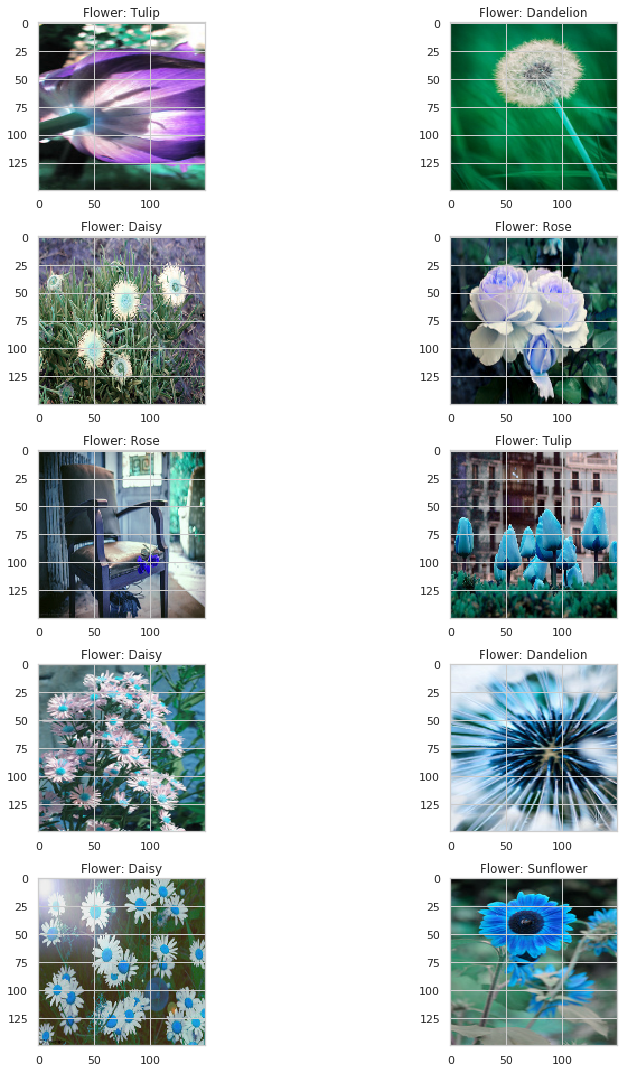

In [11]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()
        

## 2.3 ) Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding 

In [12]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

## 2.4 ) Splitting into Training and Validation Sets

In [13]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)


## 2.5 ) Setting the Random Seeds

In [14]:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

<a id="content3"></a>
## 3 ) Modelling

## 3.1 ) Specifying the Base Model

we are using the VGG16 model from the Keras.Applications library as the base model.

In [15]:
base_model=VGG16(include_top=False, weights=None,input_shape=(150,150,3), pooling='avg')

In [16]:
base_model.load_weights(weights_path)

In [17]:
base_model.summary() # VGG model Summary

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## 3.2 ) Adding our Own Fully Connected Layers

In [18]:
model=Sequential()
model.add(base_model)

model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='softmax'))

## 3.3 ) Data Augmentation to prevent Overfitting

In [19]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

## 3.4 ) Using a Learning Rate & the Summary

In [20]:
epochs=50
batch_size=128
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=2, verbose=1)

/opt/conda/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/callbacks.py:1062: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 14,847,301
Trainable params: 14,847,301
Non-trainable params: 0
_________________________________________________________________


This is now the complete summary of our model that we shall use to classify the images.

## 3.5 ) Compiling & Training the Model

#### 3.5.1 ) USING BASE MODEL AS A FEATURE EXTRACTOR.

In this method we do not tune any weights of the model.using the pretrained model as a feature extractor and just train your classifier on top of it. 

In [22]:
base_model.trainable=False # setting the VGG model to be untrainable. it wont be trained hence saving the computation power, memory and time

In [23]:
model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

In [24]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 50, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/50
21/21 [==============================] - 18s 871ms/step - loss: 1.6223 - acc: 0.2547 - val_loss: 1.5600 - val_acc: 0.2996
Epoch 2/50
21/21 [==============================] - 15s 722ms/step - loss: 1.5033 - acc: 0.3277 - val_loss: 1.4655 - val_acc: 0.3612
Epoch 3/50
21/21 [==============================] - 15s 699ms/step - loss: 1.4182 - acc: 0.4350 - val_loss: 1.3772 - val_acc: 0.4758
Epoch 4/50
21/21 [==============================] - 15s 699ms/step - loss: 1.3353 - acc: 0.5164 - val_loss: 1.2945 - val_acc: 0.5374
Epoch 5/50
21/21 [==============================] - 14s 650ms/step - loss: 1.2750 - acc: 0.5772 - val_loss: 1.2227 - val_acc: 0.6057
Epoch 6/50
21/21 [==============================] - 14s 683ms/step - loss: 1.1965 - acc: 0.6092 - val_loss: 1.1584 - val_acc: 0.6035
Epoch 7/50
21/21 [==============================] - 15s 723ms/step - loss: 1.1480 - acc: 0.6319 - val_loss: 1.1034 - val_acc: 0.6322
Epoch 8/50
21/21 [==============================] - 15s 696ms/step - 

#### 3.5.2 ) FINE TUNING BY UNFREEZING THE LAST BLOCK OF VGG16

In this section I have done fine tuning. To see the effect of the fine tuning I have first unfreezed the last block of the VGG16 model and have set it to trainable.

In [25]:
for i in range (len(base_model.layers)):
    print (i,base_model.layers[i])
  
for layer in base_model.layers[15:]:
    layer.trainable=True
for layer in base_model.layers[0:15]:
    layer.trainable=False
  

0 <keras.engine.input_layer.InputLayer object at 0x7f037d0b8320>
1 <keras.layers.convolutional.Conv2D object at 0x7f037d0b8b70>
2 <keras.layers.convolutional.Conv2D object at 0x7f037d0b8d30>
3 <keras.layers.pooling.MaxPooling2D object at 0x7f037d0f3198>
4 <keras.layers.convolutional.Conv2D object at 0x7f037d0b1cc0>
5 <keras.layers.convolutional.Conv2D object at 0x7f037d048ef0>
6 <keras.layers.pooling.MaxPooling2D object at 0x7f037d06efd0>
7 <keras.layers.convolutional.Conv2D object at 0x7f037c592160>
8 <keras.layers.convolutional.Conv2D object at 0x7f037c52e3c8>
9 <keras.layers.convolutional.Conv2D object at 0x7f037c54a128>
10 <keras.layers.pooling.MaxPooling2D object at 0x7f037c4fe0b8>
11 <keras.layers.convolutional.Conv2D object at 0x7f037c4fe080>
12 <keras.layers.convolutional.Conv2D object at 0x7f037c518470>
13 <keras.layers.convolutional.Conv2D object at 0x7f037c4b3048>
14 <keras.layers.pooling.MaxPooling2D object at 0x7f037c4e50f0>
15 <keras.layers.convolutional.Conv2D object at 

In [26]:
model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

In [27]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 50, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/50
21/21 [==============================] - 15s 720ms/step - loss: 0.5819 - acc: 0.8029 - val_loss: 0.6042 - val_acc: 0.7896
Epoch 2/50
21/21 [==============================] - 14s 677ms/step - loss: 0.5795 - acc: 0.7931 - val_loss: 0.6038 - val_acc: 0.7874
Epoch 3/50
21/21 [==============================] - 15s 693ms/step - loss: 0.5726 - acc: 0.7994 - val_loss: 0.5989 - val_acc: 0.7896
Epoch 4/50
21/21 [==============================] - 15s 705ms/step - loss: 0.5671 - acc: 0.8037 - val_loss: 0.5979 - val_acc: 0.7919
Epoch 5/50
21/21 [==============================] - 14s 679ms/step - loss: 0.5761 - acc: 0.8020 - val_loss: 0.5960 - val_acc: 0.7941
Epoch 6/50
21/21 [==============================] - 14s 669ms/step - loss: 0.5581 - acc: 0.8087 - val_loss: 0.5942 - val_acc: 0.7963
Epoch 7/50
21/21 [==============================] - 14s 676ms/step - loss: 0.5578 - acc: 0.8104 - val_loss: 0.5910 - val_acc: 0.7930
Epoch 8/50
21/21 [==============================] - 16s 739ms/step - 

79.3% validation accuracy achieved and in previous model we got 78.7% validation accuracy little bit increase

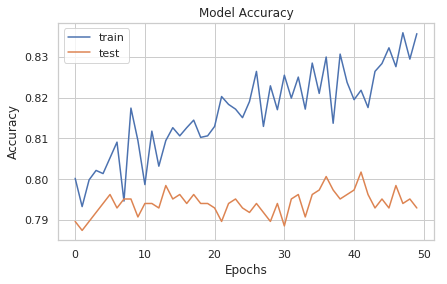

In [28]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

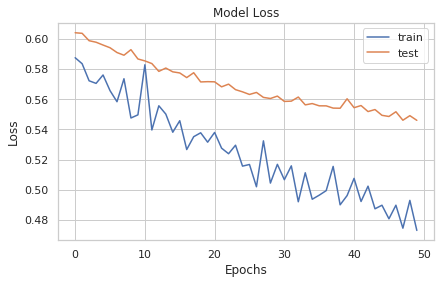

In [29]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

#### 3.5.3) UNFREEZING THE LAST 2 BLOCKS

Similarly unffreezing the last 2 blocks of the VGG16model.

In [30]:
for i in range (len(base_model.layers)):
    print (i,base_model.layers[i])
  
for layer in base_model.layers[11:]:
    layer.trainable=True
for layer in base_model.layers[0:11]:
    layer.trainable=False
  

0 <keras.engine.input_layer.InputLayer object at 0x7f037d0b8320>
1 <keras.layers.convolutional.Conv2D object at 0x7f037d0b8b70>
2 <keras.layers.convolutional.Conv2D object at 0x7f037d0b8d30>
3 <keras.layers.pooling.MaxPooling2D object at 0x7f037d0f3198>
4 <keras.layers.convolutional.Conv2D object at 0x7f037d0b1cc0>
5 <keras.layers.convolutional.Conv2D object at 0x7f037d048ef0>
6 <keras.layers.pooling.MaxPooling2D object at 0x7f037d06efd0>
7 <keras.layers.convolutional.Conv2D object at 0x7f037c592160>
8 <keras.layers.convolutional.Conv2D object at 0x7f037c52e3c8>
9 <keras.layers.convolutional.Conv2D object at 0x7f037c54a128>
10 <keras.layers.pooling.MaxPooling2D object at 0x7f037c4fe0b8>
11 <keras.layers.convolutional.Conv2D object at 0x7f037c4fe080>
12 <keras.layers.convolutional.Conv2D object at 0x7f037c518470>
13 <keras.layers.convolutional.Conv2D object at 0x7f037c4b3048>
14 <keras.layers.pooling.MaxPooling2D object at 0x7f037c4e50f0>
15 <keras.layers.convolutional.Conv2D object at 

In [31]:
model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

In [32]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 50, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/50
21/21 [==============================] - 15s 719ms/step - loss: 0.4790 - acc: 0.8305 - val_loss: 0.5459 - val_acc: 0.7941
Epoch 2/50
21/21 [==============================] - 15s 702ms/step - loss: 0.4686 - acc: 0.8370 - val_loss: 0.5482 - val_acc: 0.7941
Epoch 3/50
21/21 [==============================] - 15s 705ms/step - loss: 0.4781 - acc: 0.8361 - val_loss: 0.5448 - val_acc: 0.7941
Epoch 4/50
21/21 [==============================] - 15s 696ms/step - loss: 0.4711 - acc: 0.8343 - val_loss: 0.5449 - val_acc: 0.7952
Epoch 5/50
21/21 [==============================] - 14s 673ms/step - loss: 0.4744 - acc: 0.8312 - val_loss: 0.5437 - val_acc: 0.7985
Epoch 6/50
21/21 [==============================] - 14s 661ms/step - loss: 0.4683 - acc: 0.8334 - val_loss: 0.5442 - val_acc: 0.7952
Epoch 7/50
21/21 [==============================] - 15s 710ms/step - loss: 0.4676 - acc: 0.8340 - val_loss: 0.5431 - val_acc: 0.7963
Epoch 8/50
21/21 [==============================] - 15s 696ms/step - 

In [ ]:
80.73% validation accuracy and previously was 79.3%

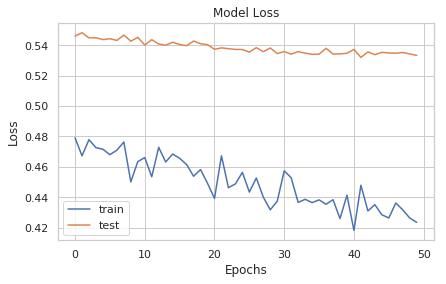

In [33]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

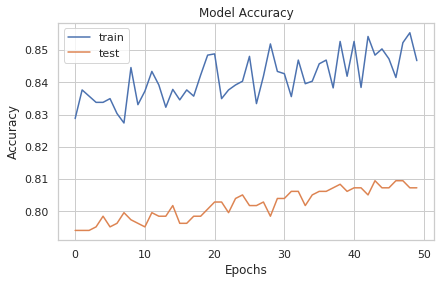

In [34]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

#### 3.5.4 ) TRAINING THE ENTIRE MODEL FROM SCRATCH

Finally I have tried to train the model from scratch. Note this is not reasonable though as our data is also not much similar with the imagenet data plus we are quite short of data as we only have around 4200 images.

Hence this model is quite prone to overfitting and I have done this just to check that the results validate with the though-process.

In [35]:
model=Sequential()
model.add(base_model)

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5,activation='softmax'))


for layer in base_model.layers:
    layer.trainable=True

model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

In [36]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 50, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/50
21/21 [==============================] - 15s 725ms/step - loss: 1.6973 - acc: 0.2892 - val_loss: 1.4316 - val_acc: 0.4020
Epoch 2/50
21/21 [==============================] - 14s 686ms/step - loss: 1.2841 - acc: 0.4914 - val_loss: 1.1393 - val_acc: 0.5573
Epoch 3/50
21/21 [==============================] - 15s 709ms/step - loss: 1.0377 - acc: 0.6110 - val_loss: 0.9872 - val_acc: 0.6090
Epoch 4/50
21/21 [==============================] - 14s 668ms/step - loss: 0.9393 - acc: 0.6519 - val_loss: 0.8985 - val_acc: 0.6586
Epoch 5/50
21/21 [==============================] - 14s 676ms/step - loss: 0.8613 - acc: 0.6979 - val_loss: 0.8405 - val_acc: 0.6883
Epoch 6/50
21/21 [==============================] - 14s 656ms/step - loss: 0.8169 - acc: 0.7103 - val_loss: 0.7983 - val_acc: 0.7059
Epoch 7/50
21/21 [==============================] - 15s 728ms/step - loss: 0.7570 - acc: 0.7344 - val_loss: 0.7641 - val_acc: 0.7181
Epoch 8/50
21/21 [==============================] - 14s 676ms/step - 

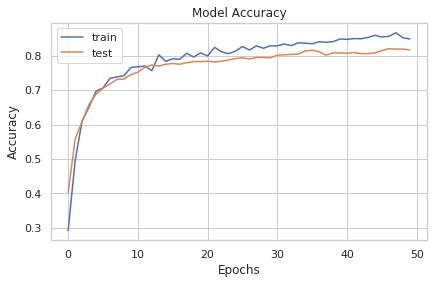

In [37]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

#### Note that the graphs as well as the results clearly show that there is significant overfitting. Also note that despite the overfitting the overall validartion accuracy has though increased from previous best of about 0.815 to a whopping 0.93.

<a id="content4"></a>
## 4 ) Visualizing Predictons on the Validation Set

In [38]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

In [47]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

# i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

[0, 2, 4, 5, 6, 7, 8, 9]

#### CORRECTLY CLASSIFIED FLOWER IMAGES

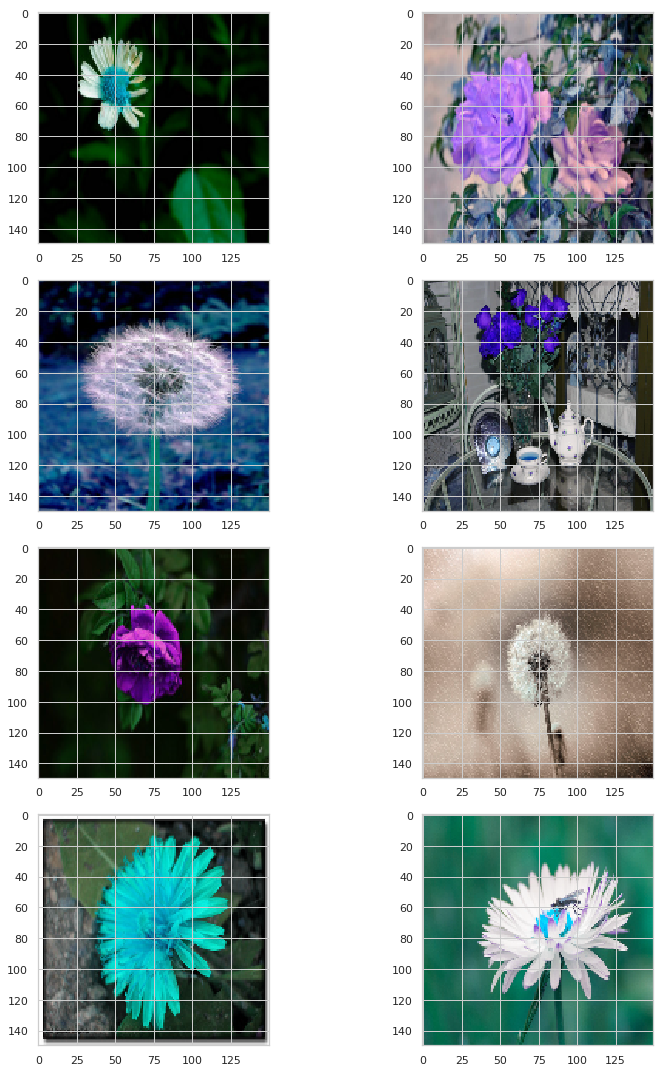

In [48]:
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
#         ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[prop_class[count]]]))))
        plt.tight_layout()
        count+=1

#### MISCLASSIFIED IMAGES OF FLOWERS

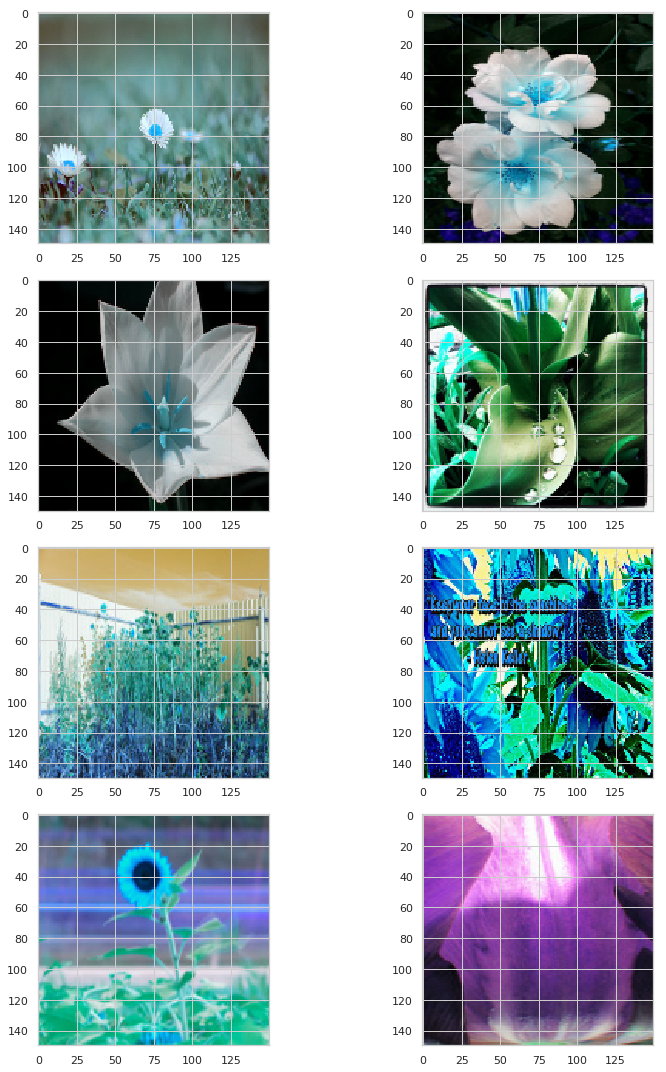

In [49]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
#         ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[mis_class[count]]]))))
        plt.tight_layout()
        count+=1